# Package Declaration
Here, we will only use three packages: numpy for handling numerical calculation, matplotlib.pyplot for visualisation, and tqdm for tracking the calculation progress.

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Standard Plot
Here is a template code for the standard plot, as we will be using them a lot in the notebook.

In [ ]:
def standard_plot(axis):
    axis.plot(np.arange(0, 5), np.ones_like(np.arange(0, 5)), label = 'exact')
    axis.set_xlim(0, 3)
    axis.set_ylim(0, 2.3)
    axis.set_xlabel(r'$t$')
    axis.set_ylabel(r'$\Delta E$')
    axis.legend()

# First Metropolis Implementation

Here, we construct a base class for the 1D QM metropolis algorithm. There are several variables that are always required for the calculations. Some are related to the physical system, while others are related to the metropolis sampling. Variables that are fit into the first category are: lattice separation $a$, particle mass $m$, and number of lattice sites $N$ (such that the length of the system is $aN$). The variables which fall into the second category are maximum update size $\epsilon$, number of configurations generated, number of configurations discarded due to correlation, and number of update for generating each configuration.

## Metropolis update

The metropolis take the lattice configuration $x$ as an input and produce the next configuration $x'$ as an output. First, we generate the update size proposal for each lattice sites

```
dx = np.random.uniform(-self.eps, self.eps, len(x))
```

These proposals may increase/decrease the total action of the system. Remember that the the harmonic oscillator action is given by
\begin{equation}
S = \int dt \left[\frac{1}{2}m\dot{x}^2 + \frac{1}{2}m\omega x^2\right] \approx a\sum_i \left[\frac{1}{2}\left(\frac{x_{i+1} - x_i}{a}\right)^2 + \frac{1}{2}x_i^2\right]
\end{equation}
where we have set $m = m\omega = 1$ in the simple discretised approximation. The first term corresponds to the kinetic energy of the system, while the second term quantifies the potential energy. Changing $x_i \rightarrow x_i + \delta x_i$ will results in the following differences (for each sites):
\begin{align}
\Delta K &= \frac{a}{2}\left[\left(\frac{x_{i+1} - x_i - \delta x_i}{a}\right)^2 + \left(\frac{x_{i} + \delta x_i - x_{i-1}}{a}\right)^2\right] - \frac{a}{2}\left[\left(\frac{x_{i+1} - x_i}{a}\right)^2 + \left(\frac{x_{i} - x_{i-1}}{a}\right)^2\right]\\
&= a~\delta x_i \left[x_i + 2 \delta x_i - x_{i+1} - x_{i-1}\right]\\
\Delta V &= \frac{a}{2}(x_i + \delta x_i)^2 - \frac{a}{2}x_i^2 = \frac{a}{2}\delta x_i(\delta x_i + 2x_i)
\end{align}

In this implementation, we gradually propose an update for $x_i$, starting from the left-most site ($i = 0$) to the right-most site ($i = N - 1$). For each update, we compute $\Delta S = \Delta K + \Delta V$, and accept the update if $\Delta S < 0 \rightarrow \exp(-\Delta S) > 1$, so that the action is always decreasing. We may also accept the update if $\Delta S > 0$ though, but with a smaller probability $P = \exp(-\Delta S)$. This is implemented in the following lines:

```
p_accept = np.exp(-ds)
p_accept = min(1, p_accept)
draw = np.random.uniform(0, 1)
if draw >= p_accept:
    dx[i] = 0
```

By continuing until all update proposals have been considered, we have completed exactly one update.

## Running the algorithm

We start the run by proposing a trivial configurations, $\{x\} = \{0\}$. To avoid correlation between configurations, we discard $n_{corr}$ of configurations before accepting the next one. A special case is in the beginning of the metropolis algorithm, where we wait until the configurations has been "thermalised" by discarding $n_{update} * n_{corr}$ configurations. These are depicted in the following lines

```
for i in range(self.n * self.Ncr):
    x = self.update(x)

two_points = []
for i in tqdm(range(self.Ncf)):
    for j in range(self.Ncr):
        x = self.update(x)
    two_point = self.propagator(x)
    two_points.append(two_point)
```

## Computing the observables

The last two lines in the last section shows the computation of "propagator", or sometimes known as "correlator" or "two-point functions". This is one of computable observables (and the one we used throughout the notebook). It is formulated as
\begin{equation}
G(t_i) = \frac{1}{N}\sum_{cfgs} \sum_k x_{k + i}x_{k} 
\end{equation}

To obtain the propagator, a peculiar convolution is performed, utilising ```np.convolve``` to achieve fastest implementation (a faster one might exists, but this is one that I found so far). The propagators are then averaged over all configurations, and used to compute the excitation energy $\Delta E_i = \partial \ln(G(t))/\partial t \approx \frac{1}{a}\ln(G(t_i) / G(t_{i+1}))$. 

```
two_point = np.mean(self.two_points, axis = 0)
energy = np.log(np.abs(two_point[:-1] / two_point[1:])) / self.a
```

In [214]:
class Metropolis:
    #Metropolis algorithm base class
    def __init__(self, size = 0.5, mass = 1, num_latt = 20, eps = 1.4, 
                 num_conf = 1000, num_corr = 20, num_updt = 5):
        self.a = size
        self.m = mass
        self.eps = eps
        self.N = num_latt
        self.Ncf = num_conf
        self.Ncr = num_corr
        self.n   = num_updt
    
    def update(self, x):
        dx = np.random.uniform(-self.eps, self.eps, len(x))
        dp = dx * self.a * (dx + 2 * x) / 2
        draw = np.random.uniform(0, 1, len(x))
        for i in range(len(x)):
            dk = dx[i] * (dx[i] + 2 * x[i] - x[i - 1] - x[i + 1 - self.N]) / self.a
            p_accept = np.exp(- dp[i] - dk)
            if draw[i] < p_accept:
                x[i] += dx[i]
        return x 
    
    def average(self):
        two_point = np.mean(self.two_points, axis = 0)
        energy = np.log(np.abs(two_point[:-1] / two_point[1:])) / self.a
        
        return energy
    
    def propagator(self, x):
        return np.convolve(x, np.concatenate((x, x))[::-1], mode='valid')[:-1] / self.N
    
    def run_actual(self):
        x = np.zeros(self.N)
        
        for i in range(self.n * self.Ncr):
            x = self.update(x)

        two_points = []
        for i in tqdm(range(self.Ncf)):
            for j in range(self.Ncr):
                x = self.update(x)
            two_point = self.propagator(x)
            two_points.append(two_point)
        
        return np.array(two_points)
    
    def run(self):
        times = np.arange(0, (self.N - 1) * self.a, self.a)

        self.two_points = self.run_actual()
        energy = self.average()
                
        return times, energy            

Below we show computation results for different number of configurations. As can be seen, more configurations produces more accurate result. 

100%|██████████| 10000/10000 [00:12<00:00, 775.75it/s]


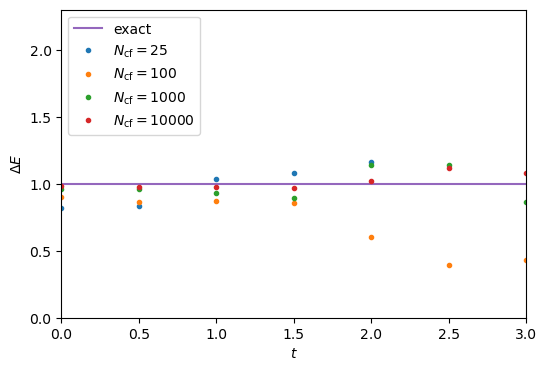

In [217]:
Ncfs = [25, 100, 1000, 10000]
energies = []
for Ncf in Ncfs:
    Base = Metropolis(num_conf = Ncf)
    times, energy = Base.run()
    energies.append(energy)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for i in range(len(Ncfs)):
    axes.errorbar(times, energies[i], fmt = '.', label = r'$N_{\text{cf}} = $' + f'{Ncfs[i]}')

standard_plot(axes)

## Trying different propagator

We might ask ourselves, what if we use different propagator, let's say, by thripling the $x_i$ before computing the propagator? We can implement it by adding options in the class. Here we call the result as ```Metropolis_ver1```. Unfortunately, the result is not as stable as the previous propagator.

In [218]:
class Metropolis_ver1(Metropolis):
    def __init__(self, *args, prop = 'linear', **kwargs):
        super().__init__(*args, **kwargs)
        self.prop = prop
    
    def propagator(self, x):
        if self.prop == 'linear':
            return np.convolve(x, np.concatenate((x, x))[::-1], mode='valid')[:-1] / self.N
    
        elif self.prop == 'triple':
            return np.convolve(x**3, np.concatenate((x**3, x**3))[::-1], mode='valid')[:-1] / self.N

100%|██████████| 10000/10000 [00:13<00:00, 747.68it/s]


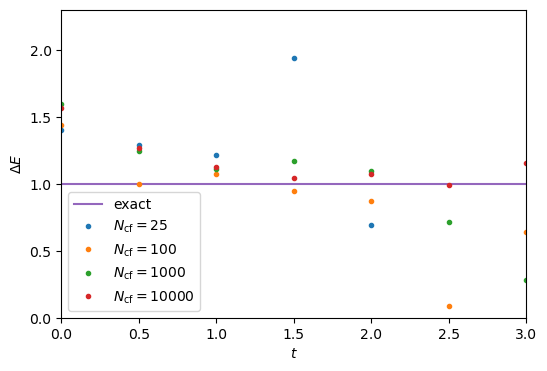

In [219]:
Ncfs = [25, 100, 1000, 10000]
energies_pow_three = []
for Ncf in Ncfs:
    Base_ver1 = Metropolis_ver1(num_conf = Ncf, prop='triple')
    times, energy = Base_ver1.run()
    energies_pow_three.append(energy)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for i in range(len(Ncfs)):
    axes.errorbar(times, energies_pow_three[i], fmt = '.', label = r'$N_{\text{cf}} = $' + f'{Ncfs[i]}')

standard_plot(axes)

## Estimating error

In the previous versions, we have only computed the average value of observables. However, we know that Monte Carlo sampling have errors! Just like we expect increasing number of configurations results in more accurate results, we should also expect it to results in smaller errors. Here, we present two methods for producing unbiased estimator that allows for robust computation of the sampling errors.

### Bootstrapping

The idea of bootstrapping is to resample the existing distributions and produce new estimate using those new samples. The resampling is done by randomly picking some number of samples (one sample can be picked more than once) from the old distributions. For example, we can pick $N_{cfgs}$ samples from $N_{cfgs}$ configurations by writing

```
self.two_points[np.random.randint(self.Ncf, size=self.Ncf)]
```

Say that we have $N_{cfgs} = 10$. The line ```np.random.randint(self.Ncf, size=self.Ncf)``` may produce something like $[0, 4, 2, 7, 4, 2, 3, 9, 1, 3]$, and when inserted into ```self.two_points[]```, resulted in new distributions. This distribution can then be averaged using ```np.mean(..., axis = 0)```, producing new $G(t_i)$, which can then be used to produce $\Delta E_i$. By repeating this process $n_{boot}$ times, we obtain new unbiased estimate of $\Delta E$.

### Binning

Just like it sounds, the idea of binning is to group the configurations and then average over each group. Here, it is implemented by reshaping the configurations from $N_{cfgs}$ to $(N_{cfgs} / n_{bin}, n_{bin})$ and averaging over the bin size, producing smaller ($N_{cfgs} / n_{bin}$) yet -hopefully- unbiased estimate of the observables. 

```
self.two_points.reshape(self.Ncf // num_err, num_err, self.N)
```

### Averaging and estimating error

Lastly, after producing new estimate using either bootstrapping or binning, we can simply compute the new average and error using

```
new_energy = np.mean(new_energies, axis = 0)
new_errors = np.std(new_energies, axis = 0)
```



In [220]:
class Metropolis_ver2(Metropolis_ver1):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def bootstrap(self, num_err):
        new_energies = []
        for i in tqdm(range(num_err)):
            new_two_points = np.mean(self.two_points[np.random.randint(self.Ncf, size=self.Ncf)], axis = 0)
            new_energy = np.log(np.abs(new_two_points[:-1] / new_two_points[1:])) / self.a
            new_energies.append(new_energy)
        
        return np.array(new_energies)
    
    def binning(self, num_err):
        new_two_points = np.mean(self.two_points.reshape(self.Ncf // num_err, num_err, self.N), axis = 1)
        new_energies = np.log(np.abs(new_two_points[:,:-1] / new_two_points[:,1:])) / self.a
        
        return new_energies
    
    def error(self, err, num_err):
        if err == 'bootstrap':
            new_energies = self.bootstrap(num_err)

        elif err == 'binning':
            new_energies = self.binning(num_err)
    
        new_energy = np.mean(new_energies, axis = 0)
        new_errors = np.std(new_energies, axis = 0)

        return new_energy, new_errors

        

Here, we obtain quite small error using both bootstrap and binning. Of course, we can expect a smaller error by adding number of configurations, number of bootstrap samples, and bin sizes.

In [223]:
Base_ver2 = Metropolis_ver2(num_conf = 10000)
times, energies = Base_ver2.run()

Base_ver2_2 = Metropolis_ver2(num_conf = 10000, prop = 'triple')
times, energies_pow_three = Base_ver2_2.run()

100%|██████████| 10000/10000 [00:13<00:00, 761.51it/s]


100%|██████████| 100/100 [00:00<00:00, 626.47it/s]


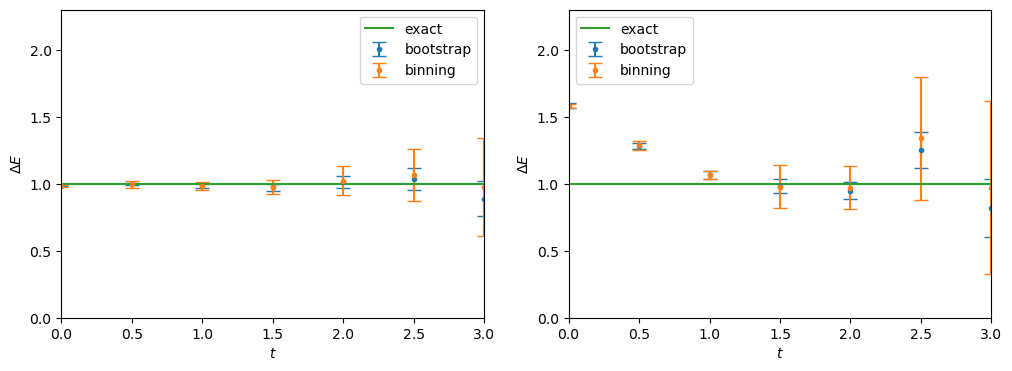

In [226]:
energy_boot, error_boot = Base_ver2.error(err = 'bootstrap', num_err= 100)
energy_binn, error_binn = Base_ver2.error(err = 'binning', num_err= 2000)
energy_boot_pow_three, error_boot_pow_three = Base_ver2_2.error(err = 'bootstrap', num_err= 100)
energy_binn_pow_three, error_binn_pow_three = Base_ver2_2.error(err = 'binning', num_err= 2000)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].errorbar(times, energy_boot, error_boot, fmt = '.', capsize=5, label = 'bootstrap')
axes[0].errorbar(times, energy_binn, error_binn, fmt = '.', capsize=5, label = 'binning')
axes[1].errorbar(times, energy_boot_pow_three, error_boot_pow_three, fmt = '.', capsize=5, label = 'bootstrap')
axes[1].errorbar(times, energy_binn_pow_three, error_binn_pow_three, fmt = '.', capsize=5, label = 'binning')

for axis in axes:
    standard_plot(axis)

## Comparing different hyperparameter

Here, we would like to see the effect of $n_{corr}$ (number of configurations discarded before accepting the new one). Our premise is that, decreasing $n_{corr}$ will increase correlation between samples, producing inaccurate results.

In [232]:
Base_ver2_3 = Metropolis_ver2(num_conf = 10000, num_corr = 1)
times, energies = Base_ver2_3.run()
energy_binn_second, error_binn_second = Base_ver2_3.error(err = 'binning', num_err= 2000)

100%|██████████| 10000/10000 [00:00<00:00, 13174.90it/s]


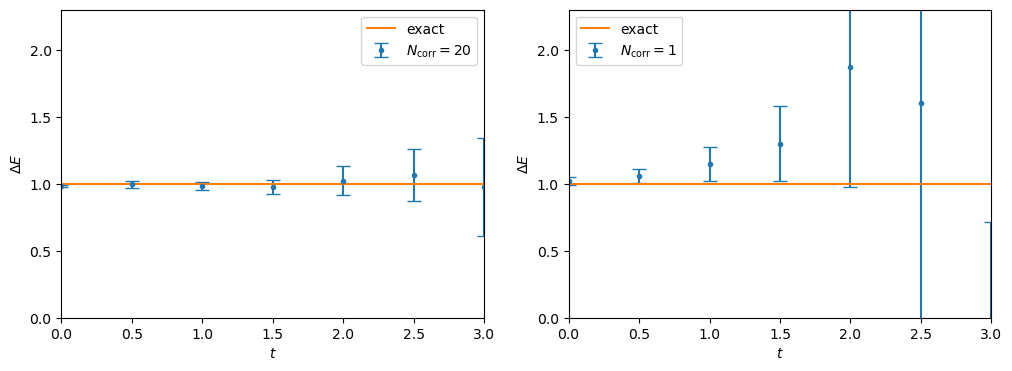

In [234]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].errorbar(times, energy_binn, error_binn, fmt = '.', capsize=5, label = r'$N_\text{corr} = 20$')
axes[1].errorbar(times, energy_binn_second, error_binn_second, fmt = '.', capsize=5, label = r'$N_\text{corr} = 1$')


for axis in axes:
    standard_plot(axis)

## Improving the action

An improvement can be made available to the action to increase the accuracy. One of such attempts is to improve the kinetic energy term. To see how the improvement can be made, we can start by integrating by parts the kinetic term

\begin{equation}
S_K = \int dt ~\frac{1}{2}\dot{x}^2 = \frac{1}{2}x\dot{x}\Bigg|_{bound} - \int dx~ \frac{1}{2}\ddot{x} = - \int dt~ \frac{1}{2}x\ddot{x} \approx - a\sum_i x_i\Delta^{(2)}x_i = - a\sum_i x_i\frac{x_{i+1} - 2x_i + x_{i-1}}{a^2}
\end{equation}

This is just another version of the kinetic energy discretisation, which gives the same form of $\delta K$. However, we can add the precision of the approximation by adding higher order term, so that

\begin{equation}
S_K \approx - a\sum_i x_i(\Delta^{(2)} - a^2(\Delta^{(2)})^2 / 12)x_i \implies \Delta K_+ = \delta x_i \left[\frac{3 \delta x_i + 6 x_i - 4 x_{i-1} - 4 x_{i + 1} + x_{i -2} + x_{i + 2}}{12 a}\right] 
\end{equation}

However, this improved kinetic action may leads to "numerical ghost" in high energy regime. To eliminate the "ghost", we can absorb the improved kinetic term into the potential, leading to improved potential term

\begin{equation}
S_V \rightarrow \frac{1}{2}x^2\left(1 + \frac{a^2}{12}\right)
\end{equation}

Note that when using improved potential, we need not to use the improved kinetic terms, and vice versa.

In [239]:
class Metropolis_ver3(Metropolis_ver2):
    def __init__(self, *args, kinetic = 'unimproved', potential = 'unimproved', **kwargs):
        super().__init__(*args, **kwargs)
        self.kinetic = kinetic
        self.potentital = potential
    
    def update(self, x):
        dx = np.random.uniform(-self.eps, self.eps, len(x))
        dp = dx * self.a * (dx + 2 * x) / 2
        if self.potentital == 'improved':
            dp *= 1 + (self.a ** 2) / 12
        draw = np.random.uniform(0, 1, len(x))
        for i in range(len(x)):
            dk = dx[i] * (dx[i] + 2 * x[i] - x[i - 1] - x[i + 1 - self.N]) / self.a
            if self.kinetic == 'improved':
                dk += dx[i] * (3 * dx[i] + 6 * x[i] - 4 * x[i - 1] - 4 * x[i + 1 - self.N] + x[i - 2] + x[i + 2 - self.N]) / (12 * self.a)    
            p_accept = np.exp(- dp[i] - dk)
            if draw[i] < p_accept:
                x[i] += dx[i]
        return x     

In [242]:
Base_ver3 = Metropolis_ver3(num_conf = 100000)
times, energy = Base_ver3.run()
energy_boot_normal, error_boot_normal = Base_ver3.error(err = 'bootstrap', num_err= 100)
energy_binn_normal, error_binn_normal = Base_ver3.error(err = 'binning', num_err= 10000)

Base_ver3_2 = Metropolis_ver3(num_conf = 100000, kinetic='improved')
times, energy_kin_imp = Base_ver3_2.run()
energy_boot_kin_imp, error_boot_kin_imp = Base_ver3_2.error(err = 'bootstrap', num_err= 100)
energy_binn_kin_imp, error_binn_kin_imp = Base_ver3_2.error(err = 'binning', num_err= 10000)

Base_ver4_2 = Metropolis_ver3(num_conf = 100000, kinetic='unimproved', potential='improved')
times, energy_pot_imp = Base_ver4_2.run()
energy_boot_pot_imp, error_boot_pot_imp = Base_ver4_2.error(err = 'bootstrap', num_err= 100)
energy_binn_pot_imp, error_binn_pot_imp = Base_ver4_2.error(err = 'binning', num_err= 10000)

100%|██████████| 100/100 [00:01<00:00, 69.06it/s]


Here are the results of using different kinetic and potential term. As we can see, the improved kinetic term introduce lower values for small value of $t$. Due to the large size of samples (and the simplicity of the system), there is no meaningful difference in terms of accuracy for each choice of action.

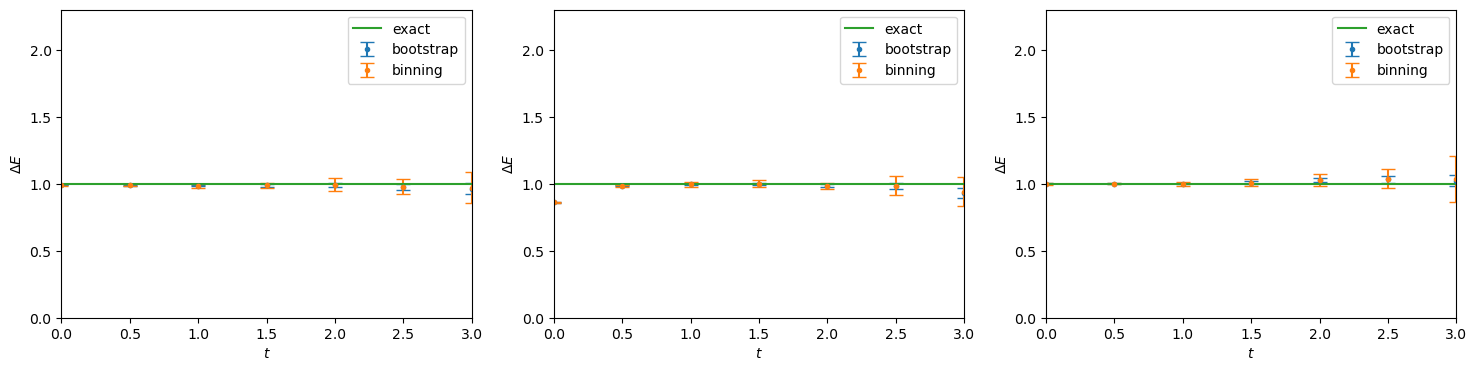

In [243]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

axes[0].errorbar(times, energy_boot_normal, error_boot_normal, fmt = '.', capsize=5, label = 'bootstrap')
axes[0].errorbar(times, energy_binn_normal, error_binn_normal, fmt = '.', capsize=5, label = 'binning')
axes[1].errorbar(times, energy_boot_kin_imp, error_boot_kin_imp, fmt = '.', capsize=5, label = 'bootstrap')
axes[1].errorbar(times, energy_binn_kin_imp, error_binn_kin_imp, fmt = '.', capsize=5, label = 'binning')
axes[2].errorbar(times, energy_boot_pot_imp, error_boot_pot_imp, fmt = '.', capsize=5, label = 'bootstrap')
axes[2].errorbar(times, energy_binn_pot_imp, error_binn_pot_imp, fmt = '.', capsize=5, label = 'binning')

for axis in axes:
    standard_plot(axis)